In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup,engine
except:
  print('[INFO] Counld not find going_modular script....downloading it')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup,engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Counld not find going_modular script....downloading it
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def set_seeds(seed:int=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source:str,
                  destination:str,
                  remove_source:bool=True)->Path:

  os.makedirs(name='data',exist_ok=True)


  data_path = Path('data/')
  image_path = data_path/destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download.")
  else:
    print(f"[INFO] Creating directory for the data. {image_path}")

  target_file = Path(source).name
  with open(data_path/target_file,'wb') as f:
    request = requests.get(source)
    print(f"[INFO] Downloading {target_file} from {source}...")
    f.write(request.content)

  with zipfile.ZipFile(data_path/target_file,'r') as zip_ref:
    print(f"[INFO] Unzipping {target_file} data...")
    zip_ref.extractall(image_path)

  if remove_source:
    os.remove(data_path/target_file)

  return image_path

In [5]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                            destination='pizza_steak_sushi')
image_path

[INFO] Creating directory for the data. data/pizza_steak_sushi
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

print(f"manually created transform: {manual_transforms}")

from going_modular.going_modular import data_setup
train_dataloader,test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)
train_dataloader,test_dataloader,class_names

manually created transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7b9006731e80>,
 ['pizza', 'steak', 'sushi'])

In [8]:
from modulefinder import test
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_trasnforms = weights.transforms()
print(f"Automatic transforms: {automatic_trasnforms}")

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=automatic_trasnforms,
                                                                           batch_size=32)
train_dataloader,test_dataloader,class_names

Automatic transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7b8f01f1a090>,
 ['pizza', 'steak', 'sushi'])

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 117MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names),bias=True)
).to(device)

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [16]:
from tqdm.auto import tqdm
from typing import Dict,List,Tuple
from going_modular.going_modular.engine import train_step,test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        writer.add_scalars(main_tag='Loss',
                           tag_scalar_dict={'train_loss':train_loss,
                                            'test_loss':test_loss},
                           global_step=epoch)

        writer.add_scalars(main_tag='Accuracy',
                           tag_scalar_dict={'train_acc':train_acc,
                                            'test_acc':test_acc},
                           global_step=epochs)

        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))

    writer.close()
    # Return the filled results at the end of the epochs
    return results

In [17]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1093 | train_acc: 0.3750 | test_loss: 0.8711 | test_acc: 0.7320
Epoch: 2 | train_loss: 0.8888 | train_acc: 0.6641 | test_loss: 0.7682 | test_acc: 0.8551
Epoch: 3 | train_loss: 0.7842 | train_acc: 0.7305 | test_loss: 0.6653 | test_acc: 0.8343
Epoch: 4 | train_loss: 0.6782 | train_acc: 0.8594 | test_loss: 0.6586 | test_acc: 0.8551
Epoch: 5 | train_loss: 0.6983 | train_acc: 0.7227 | test_loss: 0.6743 | test_acc: 0.8030


In [18]:
results

{'train_loss': [1.1092925071716309,
  0.8887876570224762,
  0.7842315807938576,
  0.6782182604074478,
  0.6982719823718071],
 'train_acc': [0.375, 0.6640625, 0.73046875, 0.859375, 0.72265625],
 'test_loss': [0.8710721929868063,
  0.768238365650177,
  0.6652558048566183,
  0.6586378812789917,
  0.6743205189704895],
 'test_acc': [0.7320075757575758,
  0.8551136363636364,
  0.8342803030303031,
  0.8551136363636364,
  0.8030303030303031]}

In [19]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [20]:
def create_writer(experiment_name:str,
                  model_name:str,
                  extra:str=None):
  from datetime import datetime
  import os

  timestamp = datetime.now().strftime('%Y-%m-%d')

  if extra:
    log_dir = os.path.join('runs',timestamp,experiment_name,model_name,extra)
  else:
    log_dir = os.path.join('runs',timestamp,experiment_name,model_name)

  print(f"[INFO] Creating new directory at {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [21]:
example_writer = create_writer(experiment_name='data_10_percent',
                               model_name='effnetb0',
                               extra='5_epochs')
example_writer

[INFO] Creating new directory at runs/2026-01-29/data_10_percent/effnetb0/5_epochs


In [22]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)



        if writer:
          writer.add_scalars(main_tag='Loss',
                           tag_scalar_dict={'train_loss':train_loss,
                                            'test_loss':test_loss},
                           global_step=epoch)

          writer.add_scalars(main_tag='Accuracy',
                            tag_scalar_dict={'train_acc':train_acc,
                                              'test_acc':test_acc},
                            global_step=epochs)

          writer.add_graph(model=model,
                          input_to_model=torch.randn(32,3,224,224).to(device))

          writer.close()

        else:
          pass

    # Return the filled results at the end of the epochs
    return results

In [23]:
data_10_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                            destination='pizza_steak_sushi')
data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                            destination='pizza_steak_sushi_20_percent')


[INFO] data/pizza_steak_sushi directory already exists, skipping download.
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
[INFO] Creating directory for the data. data/pizza_steak_sushi_20_percent
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [24]:
train_dir_10_percent = data_10_percent_path/'train'
train_dir_20_percent = data_20_percent_path/'train'

train_dir = data_10_percent_path/'test'

train_dir_10_percent,train_dir_20_percent,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [25]:
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [26]:
BATCH_SIZE = 32
train_dataloader_10_percent,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                        test_dir=test_dir,
                                                                                        transform=simple_transform,
                                                                                        batch_size=BATCH_SIZE)

train_dataloader_20_percent,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                        test_dir=test_dir,
                                                                                        transform=simple_transform,
                                                                                        batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in train_dataloader_10_percent: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in train_dataloader_20_percent: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in test_dataloader: {len(test_dataloader)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in train_dataloader_10_percent: 8
Number of batches of size 32 in train_dataloader_20_percent: 15
Number of batches of size 32 in test_dataloader: 3
Class names: ['pizza', 'steak', 'sushi']


In [27]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 197MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
summary(model=effnetb2,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [29]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False

  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=OUT_FEATURES)
  ).to(device)

  model.name = 'effnetb0'
  print(f"[INFO] Created new {model.name} model...")
  return model

def create_effnetb2():
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  for param in model.features.parameters():
    param.requires_grad = False

  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3,inplace=True),
    nn.Linear(in_features=1408,out_features=OUT_FEATURES)
  ).to(device)

  model.name = 'effnetb2'
  print(f"[INFO] Created new {model.name} model...")
  return model


In [30]:
created_model_test_effnetb0 = create_effnetb0()
created_model_test_effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model...
[INFO] Created new effnetb2 model...


In [31]:
summary(model=created_model_test_effnetb0,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [32]:
summary(model=created_model_test_effnetb2,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [33]:
num_epochs = [5,10]

models = ['effnetb0','effnetb2']

train_dataloaders = {'data_10_percent':train_dataloader_10_percent,
                     'data_20_percent':train_dataloader_20_percent}

In [34]:
%%time
from going_modular.going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
  for epochs in num_epochs:
    for model_name in models:

      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] Dataloader: {dataloader_name}")
      print(f"[INFO] Epochs: {epochs}")

      if model_name == 'effnetb0':
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f'{epochs}_epochs'))

      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir='models',
                 model_name=save_filepath)
      print("-"*50+'\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Creating new directory at runs/2026-01-29/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9280 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9398 | train_acc: 0.5391 | test_loss: 0.8326 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7280 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7013 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5818 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] Dataloader: data_10_percent
[INFO] Epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Creating new directory at runs/2026-01-29/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0845 | train_acc: 0.3984 | test_loss: 0.9591 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8949 | train_acc: 0.6445 | test_loss: 0.9036 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8490 | train_acc: 0.6758 | test_loss: 0.8055 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7029 | train_acc: 0.8516 | test_loss: 0.6937 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7016 | train_acc: 0.7305 | test_loss: 0.6516 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] Dataloader: data_10_percent
[INFO] Epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Creating new directory at runs/2026-01-29/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9280 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9398 | train_acc: 0.5391 | test_loss: 0.8326 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7280 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7013 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5818 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5409 | train_acc: 0.8750 | test_loss: 0.5932 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6397 | train_acc: 0.7031 | test_loss: 0.5925 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5071 | train_acc: 0.8008 | test_loss: 0.5386 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4676 | train_acc: 0.9219 | test_loss: 0.5325 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5791 | train_acc: 0.7344 | test_loss: 0.4894 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0845 | train_acc: 0.3984 | test_loss: 0.9591 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8949 | train_acc: 0.6445 | test_loss: 0.9036 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8490 | train_acc: 0.6758 | test_loss: 0.8055 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7029 | train_acc: 0.8516 | test_loss: 0.6937 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.7016 | train_acc: 0.7305 | test_loss: 0.6516 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5989 | train_acc: 0.7695 | test_loss: 0.6595 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6212 | train_acc: 0.8047 | test_loss: 0.6043 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.5351 | train_acc: 0.8242 | test_loss: 0.6012 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.4974 | train_acc: 0.9219 | test_loss: 0.5611 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.5294 | train_acc: 0.7969 | test_loss: 0.5456 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9633 | train_acc: 0.6062 | test_loss: 0.6667 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6933 | train_acc: 0.7812 | test_loss: 0.5816 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5024 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4179 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4503 | train_acc: 0.8646 | test_loss: 0.3826 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] Dataloader: data_20_percent
[INFO] Epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Creating new directory at runs/2026-01-29/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9896 | train_acc: 0.5208 | test_loss: 0.7830 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7137 | train_acc: 0.8187 | test_loss: 0.6525 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5771 | train_acc: 0.8917 | test_loss: 0.5537 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5228 | train_acc: 0.8500 | test_loss: 0.5141 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4659 | train_acc: 0.8688 | test_loss: 0.4452 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] Dataloader: data_20_percent
[INFO] Epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Creating new directory at runs/2026-01-29/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9633 | train_acc: 0.6062 | test_loss: 0.6667 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6933 | train_acc: 0.7812 | test_loss: 0.5816 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5024 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4179 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4503 | train_acc: 0.8646 | test_loss: 0.3826 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4219 | train_acc: 0.8938 | test_loss: 0.3726 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3983 | train_acc: 0.8625 | test_loss: 0.3387 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3435 | train_acc: 0.8958 | test_loss: 0.3489 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3729 | train_acc: 0.8938 | test_loss: 0.3443 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3833 | train_acc: 0.8938 | test_loss: 0.2842 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9896 | train_acc: 0.5208 | test_loss: 0.7830 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7137 | train_acc: 0.8187 | test_loss: 0.6525 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5771 | train_acc: 0.8917 | test_loss: 0.5537 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5228 | train_acc: 0.8500 | test_loss: 0.5141 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4659 | train_acc: 0.8688 | test_loss: 0.4452 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3797 | train_acc: 0.9104 | test_loss: 0.4617 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3602 | train_acc: 0.9229 | test_loss: 0.4180 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3310 | train_acc: 0.9000 | test_loss: 0.4133 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3507 | train_acc: 0.8875 | test_loss: 0.4369 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8604 | test_loss: 0.3770 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [36]:
# %load tensorboard
# %tensorboard --logdir runs

In [37]:
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'

best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [38]:
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"The model size is: {effnetb2_model_size} MB")

The model size is: 29 MB


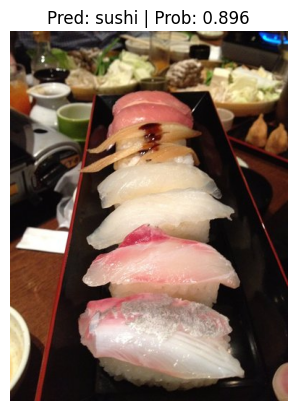

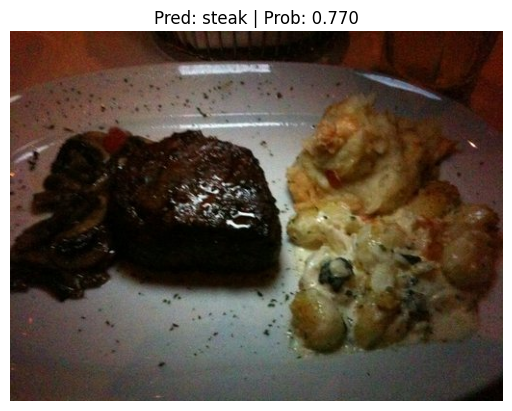

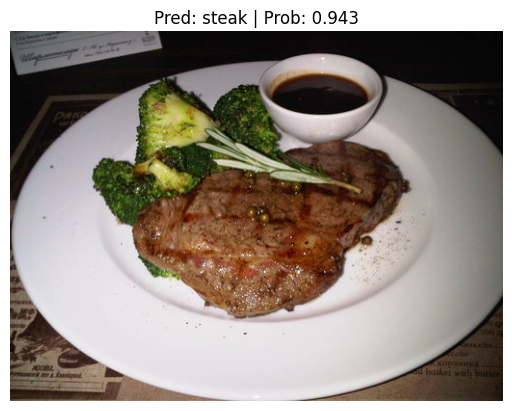

In [39]:
from going_modular.going_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path/ 'test').glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list,k=num_images_to_plot)


for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

In [40]:
import requests
from pathlib import Path

custom_image_path = Path('data/04_pizza_dad.jpeg')

if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_dad.jpeg')
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

In [41]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

UnidentifiedImageError: cannot identify image file 'data/04_pizza_dad.jpeg'